# A look into how SMOTE-ENN can increase performance when data labels are noisy
### By Ronald van den Berg

Various sources have stated that SMOTE-ENN can be a better resampling method than SMOTE when data labels are noisy and/or classes are highly overlapping.

The analysis in this notebook is aimed at finding such a case (without much success -- which makes me doubt how useful -ENN really is in the context of classifier training)

## Imports and settings

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# fix random seed for reproducibility
np.random.seed(20230703)

# Generate data

In [2]:
def generate_data(n=1000, separation=1, flip_p=0.05, class1_p=0.50, show_plots = True):
    # default settings:
    #   n = 1000         # number of rows to generate
    #   separation = 1   # amount of separation between the classes (in standard deviations)
    #   flip_p = 0.05    # proportion of flipped labels 
    #   class1_p = 0.35  # use 0.50 to get perfectly balanced classes

    # compute subset sizes
    n1 = int(class1_p * n)
    n2 = n - n1

    # generate "class 1" cases
    mu1 = np.array([0, 0])
    cov1 = np.array([[1, 0], [0, 1]])
    class1 = np.random.multivariate_normal(mu1, cov1, n1)

    # generate "class 2" cases
    mu2 = np.array([separation, 0])
    cov2 = np.array([[1, 0], [0, 1]])
    class2 = np.random.multivariate_normal(mu2, cov2, n2)

    # set set labels
    labels1 = np.ones(n1)
    labels2 = np.zeros(n2)

    # create dataframe
    X = np.concatenate((class1, class2))
    y = np.concatenate((labels1, labels2))
    df = pd.DataFrame(X, columns=['X1', 'X2'])
    df['y'] = y

    if show_plots:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.scatter(df['X1'], df['X2'], c=df['y'], cmap='bwr')
        plt.title("Original labels")

    # flip a proportion of the labels
    noisy_labels = y.copy()
    flip_indices = np.random.choice(np.arange(n), size=int(flip_p*n), replace=False)
    noisy_labels[flip_indices] = 1 - noisy_labels[flip_indices] # flipping
    df['y'] = noisy_labels

    if show_plots:
        plt.subplot(1,2,2)
        plt.scatter(df['X1'], df['X2'], c=df['y'], cmap='bwr')
        plt.title(f"Noisy labels\n({100*flip_p:.0f}% flipped)")
        plt.tight_layout()
        plt.show()
    
    return df

# Define features (X), target (y), model, and resampler

In [3]:
# define model and its parameter space
model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=20230629))
param_space = {
    'gradientboostingclassifier__n_estimators': [100, 200, 300],
    'gradientboostingclassifier__learning_rate': [0.1, 0.01, 0.001],
    'gradientboostingclassifier__max_depth': [3, 5, 10, 20]
}
    
# create the optimizer object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_space, n_iter=36, cv=5, n_jobs=6, scoring='accuracy', random_state=20230629)


# Generate data

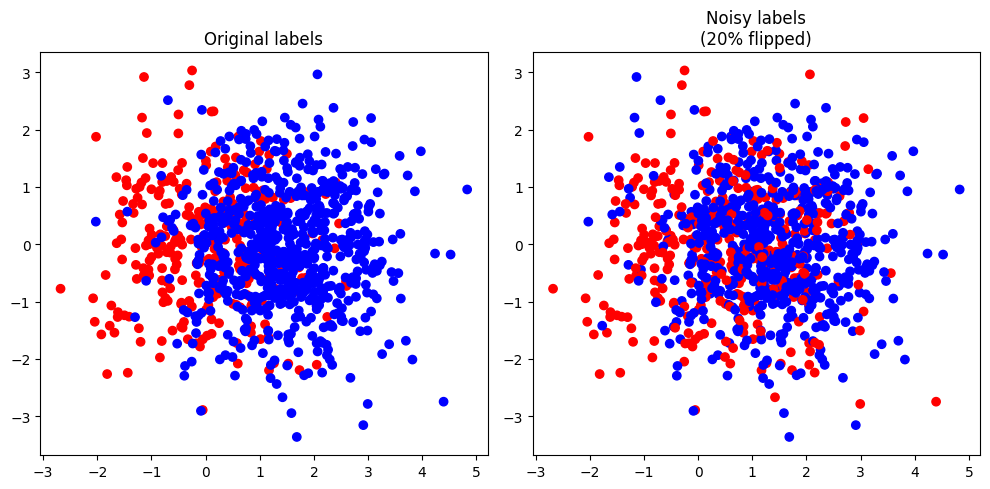

In [4]:
# generate data
df = generate_data(n=1000, separation=1.5, flip_p=0.2, class1_p=0.3, show_plots = True)

# extract features and target
X = df.drop('y', axis=1)
y = df['y']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20230629)

# Analysis 1: use SMOTE

In [5]:
resampler = SMOTE(sampling_strategy = 'all', random_state = 20230630)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
random_search.fit(X_train_resampled, y_train_resampled)
y_pred = random_search.predict(X_test)
print(f"accuracy = {accuracy_score(y_test, y_pred):.3f}")

accuracy = 0.580


# Analysis 2: use SMOTE-ENN

In [6]:
resampler = SMOTEENN(sampling_strategy = 'all', random_state = 20230630)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
random_search.fit(X_train_resampled, y_train_resampled)
y_pred = random_search.predict(X_test)
print(f"accuracy = {accuracy_score(y_test, y_pred):.3f}")

accuracy = 0.615
